<a href="https://colab.research.google.com/github/Emadddddd/Internals/blob/main/Internal_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This image is: <class 'numpy.ndarray'> with dimensions: (700, 1400, 3)


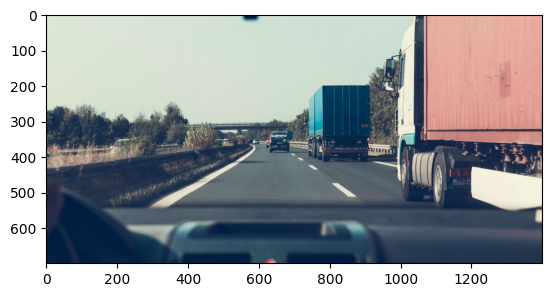

In [ ]:
image = mpimg.imread('test_images/1.jpg')

print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

In [ ]:
import os
os.listdir("test_images/")

['1.jpg']

In [ ]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold=50, high_threshold=150):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size=15):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2] 
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
            
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = mpimg.imread(os.path.join(folder, filename))
        if img is not None:
            images.append((img, filename, False))
    return images


def show_images(images, cols, figure_size=(10, 10)):
    rows = math.ceil(len(images)/cols)
    fix, ax = plt.subplots(rows, cols, figsize=figure_size)

    img_cnt = 0
    img_length = len(images)
    for i in range(rows):
        for j in range(cols):
            image, title, show_gray = images[img_cnt]
            if (rows > 1):
                ax[i][j].set_title(title, fontsize=10)
                if show_gray:
                    ax[i][j].imshow(image, cmap='gray')
                else:
                    ax[i][j].imshow(image)
            else:
                ax[j].set_title(title, fontsize=10)
                if show_gray:
                    ax[j].imshow(image, cmap='gray')
                else:
                    ax[j].imshow(image)
            img_cnt = img_cnt + 1
            if img_cnt >= img_length:
                break
        if img_cnt >= img_length:
            break
    plt.tight_layout()
    plt.show()
    
def get_changed_images(images, modifier, image_name, show_as_gray):
    changed_images = []
    for image, name, _ in images:
        changed_image = modifier(image)
        changed_images.append((changed_image, image_name, show_as_gray))
    return changed_images

def mask_white_yellow_rgb(image):
    # white
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow
    lower = np.uint8([190, 190, 0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask=mask)


def mask_white_yellow_hls(image):
    converted = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # white
    lower = np.uint8([0, 200, 0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow
    lower = np.uint8([10, 0, 100])
    upper = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask=mask)


def get_region_masked_images(images, imshape, row_top, bottom_col_left, top_col_left, top_col_right):
    region_images = []

    bottom_left = [bottom_col_left, imshape[0]]
    top_left = [top_col_left, row_top]
    bottom_right = [imshape[1], imshape[0]]
    top_right = [top_col_right, row_top]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

    for image, name, _ in images:
        masked = region_of_interest(image, vertices)
        name = "region_masked"
        region_images.append((masked, name, True))
    return region_images

def get_hough_lines_all(images):
    lines = []
    for image, name, _ in images:
        line = hough_lines(image, 1, np.pi/180, 20, 20, 300)
        lines.append(line)
    return lines


def get_hough_lines_images(original_images, canny_images, lines_all):
    hough_lines_images = []
    cnt = 0
    for image, name, _ in canny_images:
        orig_copy = np.copy(original_images[cnt][0])
        draw_lines(orig_copy, lines_all[0], thickness=1)
        name = 'hough_lines'
        hough_lines_images.append((orig_copy, name, False))
    return hough_lines_images


def get_lane_lines_all(images, lines_all, row_top):
    lane_lines_all = []
    cnt = 0
    for image, name, _ in images:
        lane_lines = get_lane_lines(image.shape, lines_all[cnt], row_top)
        lane_lines_all.append(lane_lines)
        cnt = cnt + 1
    return lane_lines_all


def get_images_with_lane_lines(images, lane_lines_all):
    results = []
    cnt = 0
    for image, name, _ in images:
        result = get_lane_lines_image(image, lane_lines_all[cnt])
        results.append((result, "result", False))
    return results

def average_lanes(lines):
    left_lines = []
    left_length = []
    right_lines = []
    right_length = []

    for line in lines:
        for col1, row1, col2, row2 in line:
            if col2 == col1:
                continue  # skip if it is a vertical line
            slope = (row2 - row1) / (col2 - col1)
            intercept = row1 - slope * col1
            length = np.sqrt((row2 - row1) ** 2 + (col2 - col1) ** 2)
            if slope < 0:  # y is reversed in a matplotlib image
                left_lines.append((slope, intercept))
                left_length.append((length))
            else:
                right_lines.append((slope, intercept))
                right_length.append((length))

    left_lane = None
    right_lane = None

    # prefer longer lines
    if len(left_length) > 0:
        left_lane = np.dot(left_length, left_lines) / np.sum(left_length)

    if len(right_length) > 0:
        right_lane = np.dot(right_length, right_lines) / np.sum(right_length)

    #(slope,intercept), (slope,intercept)
    return left_lane, right_lane


def get_points(row_bottom, row_top, line):
    if line is None:
        return None

    slope, intercept = line

    col_bottom = int((row_bottom - intercept) / slope)
    col_top = int((row_top - intercept) / slope)

    return ((col_bottom, int(row_bottom)), (col_top, int(row_top)))
  
def get_lane_lines(imshape, lines, row_top):
    left_lane, right_lane = average_lanes(lines)

    left_line = get_points(imshape[0], row_top, left_lane)
    right_line = get_points(imshape[0], row_top, right_lane)

    return left_line, right_line


def get_lane_lines_image(image, lines, color= [255, 0, 0], thickness=20):
    
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, line[0], line[1], color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)

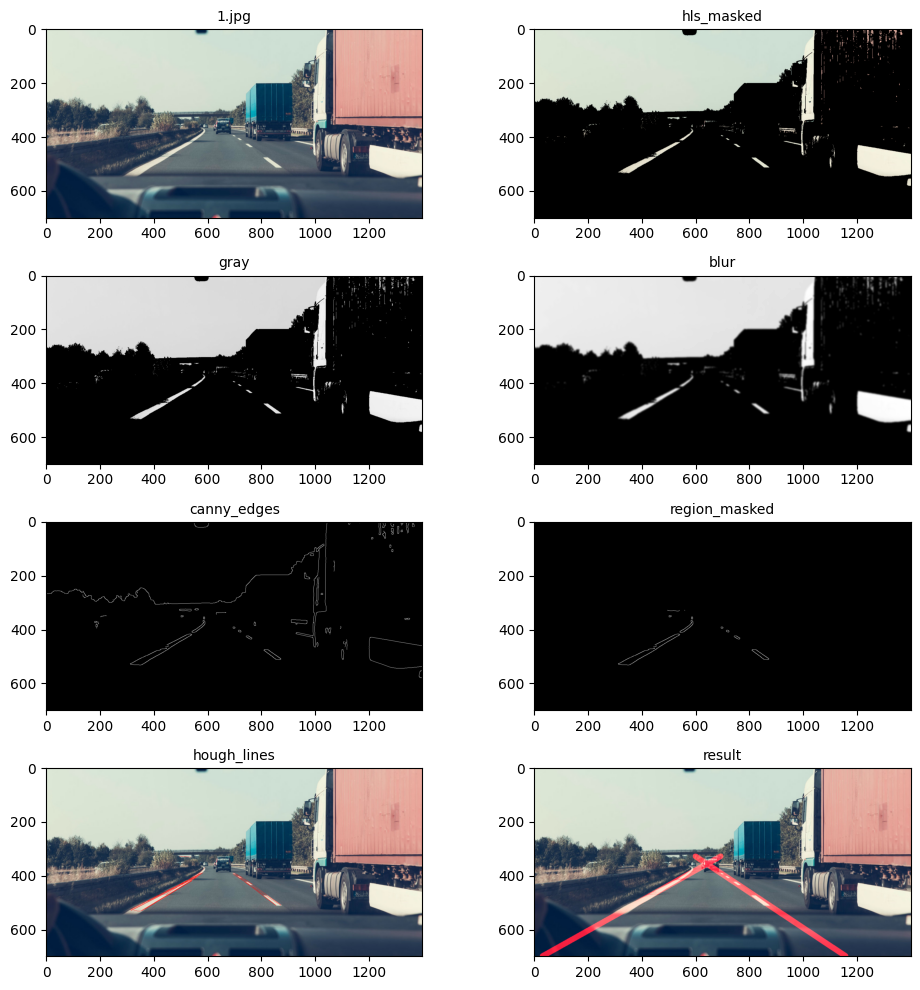

In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
images_folder = 'test_images'
images = load_images(images_folder)

images_to_show = []
images_to_show.append(images[0])
#show_images(images, 2)

hls_masked_images = get_changed_images(images, mask_white_yellow_hls, 'hls_masked', False)
images_to_show.append(hls_masked_images[0])

gray_images = get_changed_images(hls_masked_images, grayscale, "gray", True)
images_to_show.append(gray_images[0])

blur_images = get_changed_images(gray_images, gaussian_blur, "blur", True)
images_to_show.append(blur_images[0])

canny_images = get_changed_images(blur_images, canny, "canny_edges", True)
images_to_show.append(canny_images[0])

row_top = 330
bottom_col_left = 100
top_col_left = 450
top_col_right = 560

region_masked_images = get_region_masked_images(canny_images, images[0][0].shape, row_top, bottom_col_left, top_col_left, top_col_right)
images_to_show.append(region_masked_images[0])

hough_lines_all = get_hough_lines_all(region_masked_images)

h_images = get_hough_lines_images(images, region_masked_images, hough_lines_all)
images_to_show.append(h_images[0])

lane_lines_all = get_lane_lines_all(images, hough_lines_all, row_top)
results = get_images_with_lane_lines(images, lane_lines_all)
images_to_show.append(results[0])

show_images(images_to_show, 2)

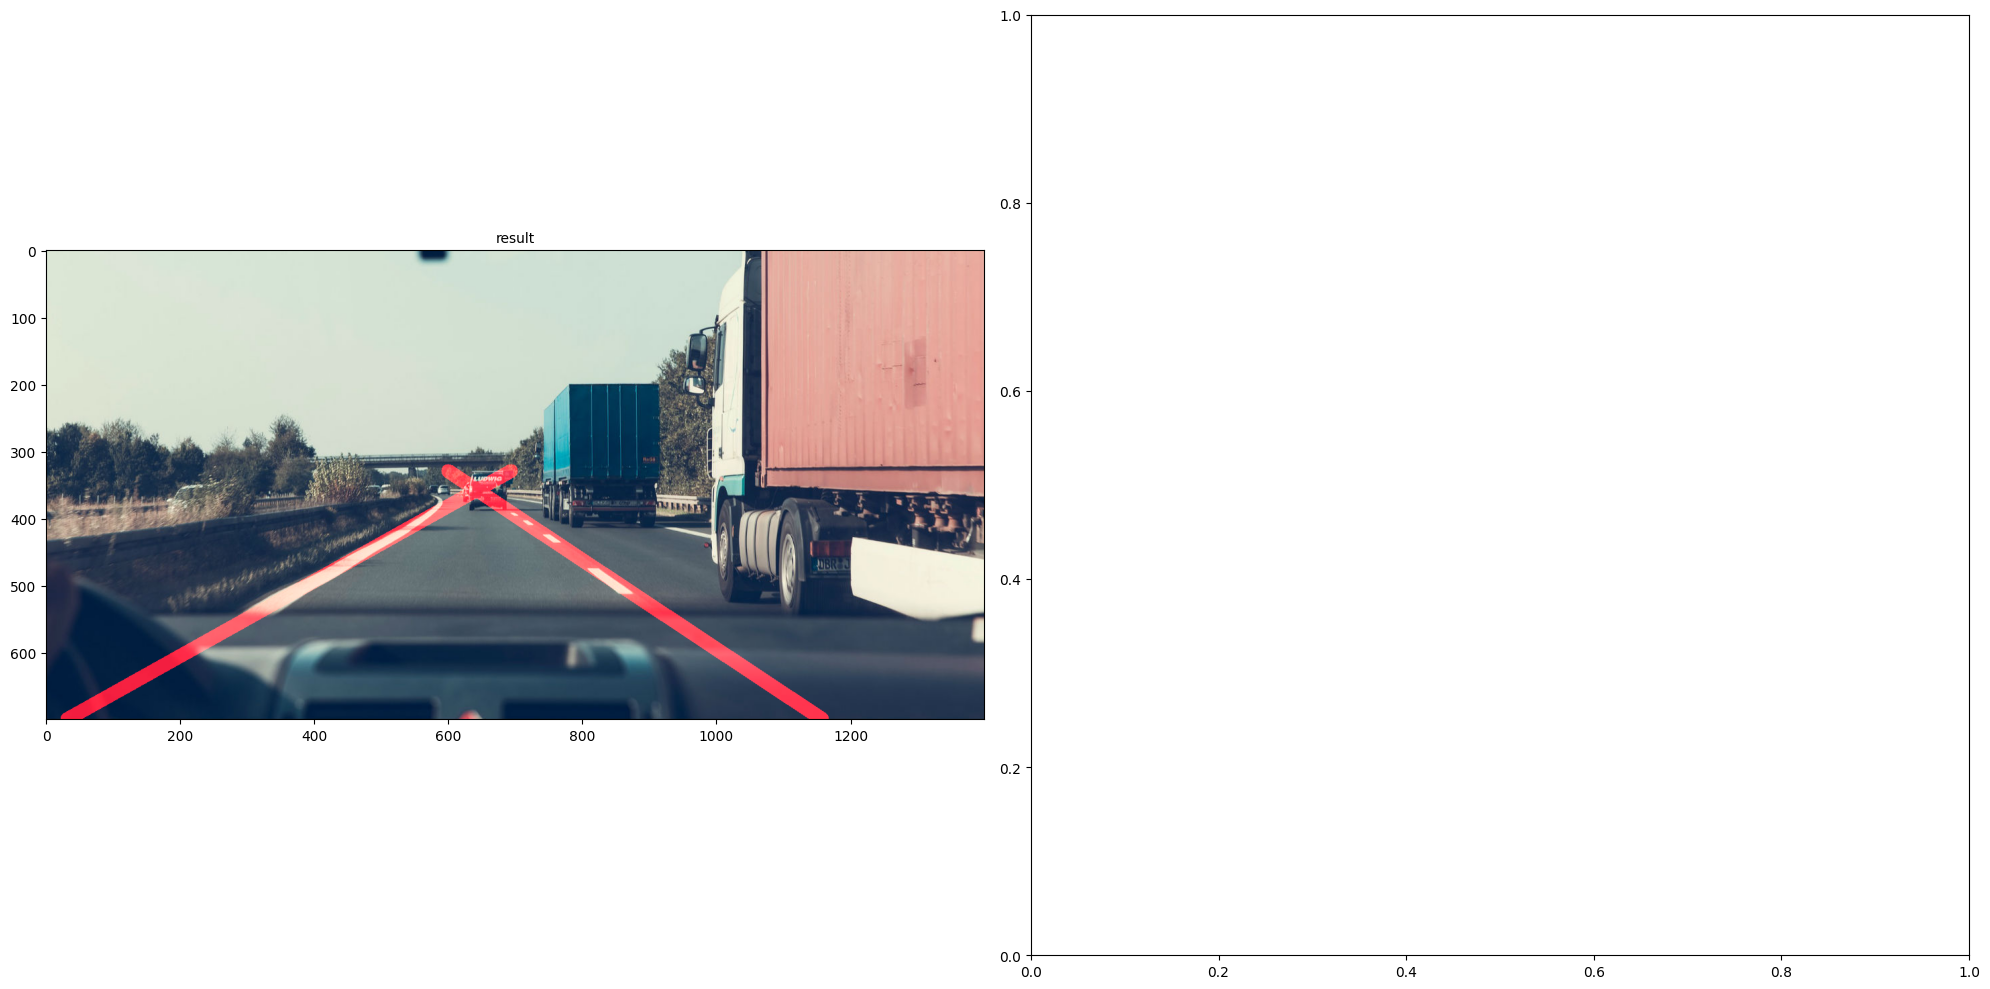

In [ ]:
show_images(results, 2, (20,10))